# Python with Fantasy Football

Part 2 (https://www.fantasyfootballdatapros.com/blog/intermediate/2)

## Correlation Matrices and Stacking Players

The question we’re going to try to answer is about “stacking”. In Fantasy Football stacking is starting two or more players from the same team.

In other fields, for example stocks and shares, diversifying is encouraged and a safer method. Diversification is one of the only free lunches in economics, as you have the potential to reduce your risk without altering your return. But should these beliefs be applied to Fantasy Football?

Sometimes you are projected to lose by a lot and you might actually want to increase your risk. Another principle in both Finance and Fantasy Football is that you can actually increase your potential reward by increasing your level of risk exposure.

In [40]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

In [41]:
#Import File
df = pd.read_csv(r'/Users/henryrodwell/Desktop/Data Science Projects/2019.csv') 
df.head()

,Rk,Player,Tm,FantPos,Age,G,GS,Cmp,Att,Yds,...,TD.3,2PM,2PP,FantPt,PPR,DKPt,FDPt,VBD,PosRank,OvRank
0,1,Christian McCaffrey*\McCaCh01,CAR,RB,23,16,16,0,2,0,...,19,1.0,NaN,355.0,471.2,477.2,413.2,215.0,1,1.0
1,2,Lamar Jackson*\JackLa00,BAL,QB,22,15,15,265,401,3127,...,7,NaN,1.0,418.0,417.7,431.7,423.7,152.0,1,2.0
2,3,Derrick Henry*\HenrDe00,TEN,RB,25,15,15,0,0,0,...,18,NaN,NaN,277.0,294.6,303.6,285.6,136.0,2,3.0
3,4,Aaron Jones\JoneAa00,GNB,RB,25,16,16,0,0,0,...,19,NaN,NaN,266.0,314.8,322.8,290.3,125.0,3,4.0
4,5,Ezekiel Elliott*\ElliEz00,DAL,RB,24,16,16,0,0,0,...,14,NaN,NaN,258.0,311.7,319.7,284.7,117.0,4,5.0


In [42]:
#View Headings
df.columns

Index(['Rk', 'Player', 'Tm', 'FantPos', 'Age', 'G', 'GS', 'Cmp', 'Att', 'Yds',
       'TD', 'Int', 'Att.1', 'Yds.1', 'Y/A', 'TD.1', 'Tgt', 'Rec', 'Yds.2',
       'Y/R', 'TD.2', 'Fmb', 'FL', 'TD.3', '2PM', '2PP', 'FantPt', 'PPR',
       'DKPt', 'FDPt', 'VBD', 'PosRank', 'OvRank'],
      dtype='object')

In [43]:
#Drop Unnecessary Columns
df.drop(['Rk', '2PM', '2PP', 'FantPt', 'DKPt', 'FDPt', 'VBD', 'PosRank', 'OvRank', 'PPR', 'Fmb', 'GS', 'Age', 'Tgt', 'Y/A', 'Att', 'Att.1', 'Cmp', 'Y/R'], axis=1, inplace=True)

#Clean Player Column
df['Player'] = df['Player'].apply(lambda x: x.split('*')[0]).apply(lambda x: x.split('\\')[0])

#Rename Columns
df.rename({
'FantPos' : 'Pos',   
'TD': 'PassingTD',
'TD.1': 'RushingTD',
'TD.2': 'ReceivingTD',
'TD.3': 'TotalTD',
'Yds': 'PassingYDs',
'Yds.1': 'RushingYDs',
'Yds.2': 'ReceivingYDs',
}, axis=1, inplace=True)

#Show Results
df.head()

,Player,Tm,Pos,G,PassingYDs,PassingTD,Int,RushingYDs,RushingTD,Rec,ReceivingYDs,ReceivingTD,FL,TotalTD
0,Christian McCaffrey,CAR,RB,16,0,0,0,1387,15,116,1005,4,0,19
1,Lamar Jackson,BAL,QB,15,3127,36,6,1206,7,0,0,0,2,7
2,Derrick Henry,TEN,RB,15,0,0,0,1540,16,18,206,2,3,18
3,Aaron Jones,GNB,RB,16,0,0,0,1084,16,49,474,3,2,19
4,Ezekiel Elliott,DAL,RB,16,0,0,0,1357,12,54,420,2,2,14


In [44]:
#Create Columns for Fantasy Points
df['FantasyPoints'] = (df['PassingYDs']*0.04 + df['PassingTD']*4 - df['Int']*2 + df['RushingYDs']*0.1 + df['RushingTD']*6 + df['Rec']*1 + df['ReceivingYDs']*0.1 + df['ReceivingTD']*6 - df['FL']*2)

df['FantasyPoints/G'] = df['FantasyPoints']/df['G']

df = df[['Tm', 'Pos', 'FantasyPoints', 'FantasyPoints/G']]

df.head()

,Tm,Pos,FantasyPoints,FantasyPoints/G
0,CAR,RB,469.20,29.32500
1,BAL,QB,415.68,27.71200
2,TEN,RB,294.60,19.64000
3,GNB,RB,314.80,19.67500
4,DAL,RB,311.70,19.48125


In [45]:
#Remove Players on Two or More Teams
df = df[df['Tm'] != '2TM']
df = df[df['Tm'] != '3TM']

Next, we remove players who played on two or more teams. Unfortunately, this means the model won’t be 100% perfect. Looking through the original CSV, we notice that players that were traded or dropped and signed by other teams throughout the course of the year are listed as either “2TM” or “3TM” under the ‘Tm’ column.If I were to attempt to fix every example of this in this post, this model would get very long.

The syntax for how to filter out values we do not want is almost exactly similar to how we filter based on values we do want. Instead of using a == operator like we do to separate DataFrames based on position, we use a != operator.

Now we want to create a correlation matrix, and then create a heat map to help us visualize the results.

We want to find the correlation coefficients between QB1, RB1, RB2, WR1, WR2, WR3, and TE1 numbers. We are going to do this by first finding the QB1, RB1, RB2, etc… for each team based on total FantasyPoints scored, and then use those players FantasyPoints/GM value to determine the final correlation numbers.

In [46]:
#Separate Dataframes by Position
rb_df = df[df['Pos'] == 'RB']
qb_df = df[df['Pos'] == 'QB']
wr_df = df[df['Pos'] == 'WR']
te_df = df[df['Pos'] == 'TE']

rb_df.head()

,Tm,Pos,FantasyPoints,FantasyPoints/G
0,CAR,RB,469.2,29.325000
2,TEN,RB,294.6,19.640000
3,GNB,RB,314.8,19.675000
4,DAL,RB,311.7,19.481250
5,MIN,RB,292.4,20.885714


Now we want to create a correlation matrix, and then create a heat map to help us visualize the results.

We want to find the correlation coefficients between QB1, RB1, RB2, WR1, WR2, WR3, and TE1 numbers. We are going to do this by first finding the QB1, RB1, RB2, etc… for each team based on total FantasyPoints scored, and then use those players FantasyPoints/GM value to determine the final correlation numbers.

In [47]:
#Create Real Dataframe
def get_top_players(df, n):
    return df.groupby('Tm').apply(lambda x: x.nlargest(n, ['FantasyPoints']).min()).reset_index(drop=True)


This function helps produce all 7 separate DataFrames and reduces redundancy in our code.

First, we pass in our original DataFrame, and then use an extremely powerful tool in pandas called groupby. It’s a built in method that allows us to group a DataFrame based on some column. We are grouping by ‘Tm’ here because we want to evaluate QB1, RB1, RB2, etc.. numbers for each and every team. The reason groupby is so powerful is because now we can apply a function across each and every group. We use .apply to do this and we apply another built-in DataFrame method called nlargest. The nlargest method returns the top n largest values (For example, if n=3, it will return the top 3 values), based on the arguments given — n, and column value. The syntax for this required you to wrap the column name in brackets. In this case, we want to find the players with the most fantasy points (or 2nd or 3rd most for RB2, WR2, and WR3) at their given positions on their given team.

In pandas, the .min() method is going to return the smallest value in a given group. Let’s say we want to create our WR3 DataFrame. We’d pass in wr_df2 as our original DataFrame. We’d pass in n=3. This will return us the top 3 WR’s for a given team. But if we want the WR3 for that team, we want the player with the lowest FantasyPoints in that subgroup of the top 3 WR’s

The .reset_index(drop=True) is simply to reverse the indexing changes we made with groupby.

In [48]:
#Create New Dataframes for Each Position
qb_df = get_top_players(qb_df, 1)
te_df = get_top_players(te_df, 1)
rb1_df = get_top_players(rb_df, 1)
rb2_df = get_top_players(rb_df, 2)
wr1_df = get_top_players(wr_df, 1)
wr2_df = get_top_players(wr_df, 2)
wr3_df = get_top_players(wr_df, 3)

#Rename Dictionaries
new_names = {
    'QB1': qb_df,
    'TE1': te_df,
    'RB1': rb1_df,
    'RB2': rb2_df,
    'WR1': wr1_df,
    'WR2': wr2_df,
    'WR3': wr3_df
}

#Iterate over Dictionary of Dataframes
for name, new_df in new_names.items():
    new_df.rename({'FantasyPoints/G': name}, axis=1, inplace=True)
    new_df.drop(['Pos', 'FantasyPoints'], axis=1, inplace=True)
    new_df.set_index('Tm', inplace=True)

For each DataFrame, we are renaming the FantasyPoints/GM column, setting axis = 1 to tell pandas we want to commit the change on the column axis, and setting inplace = True to save our changes as permanent.

Drop ‘Pos’ and ‘FantasyPoints’ columns, as they are no longer needed. We do the same thing with axis and inplace. We use the method .set_index() to set our column ‘Tm’ as the DataFrame index.

In [49]:
df = pd.concat([qb_df, te_df, rb1_df, rb2_df, wr1_df, wr2_df, wr3_df], axis=1)
df.head()

,QB1,TE1,RB1,RB2,WR1,WR2,WR3
Tm,,,,,,,
ARI,17.455000,3.180000,10.884615,6.369231,11.087500,11.087500,6.536364
ATL,17.689333,14.592308,14.114286,5.600000,18.273333,15.000000,6.175000
BAL,27.712000,13.813333,15.900000,5.787500,10.457143,5.943750,3.756250
BUF,17.660000,5.313333,12.325000,5.931250,14.654667,12.053333,4.220000
CAR,13.652308,8.835714,29.325000,1.831250,15.366667,10.731250,3.556250


So now we have the QB1, RB1, RB2, WR1, WR2, WR3, and TE1 FantasyPoints/GM numbers for each NFL team in the past 2019 season. Now we can move on to creating a correlation matrix and heat map.

In [50]:
#View Correlation Matrix
df.corr()

,QB1,TE1,RB1,RB2,WR1,WR2,WR3
QB1,1.000000,0.324345,0.028974,-0.085875,0.229304,0.215667,0.156623
TE1,0.324345,1.000000,0.158724,0.051356,-0.012109,-0.015613,-0.034101
RB1,0.028974,0.158724,1.000000,-0.170231,0.062852,-0.024351,-0.173941
RB2,-0.085875,0.051356,-0.170231,1.000000,0.195120,-0.271088,-0.391543
WR1,0.229304,-0.012109,0.062852,0.195120,1.000000,0.245053,0.029375
WR2,0.215667,-0.015613,-0.024351,-0.271088,0.245053,1.000000,0.410028
WR3,0.156623,-0.034101,-0.173941,-0.391543,0.029375,0.410028,1.000000


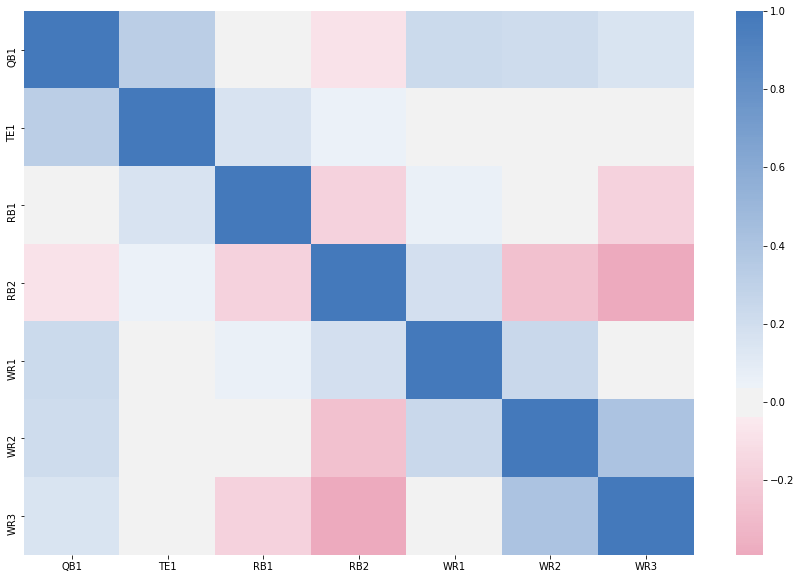

In [51]:
#Create Matrix
corrMatrix = df.corr()

fig, ax = plt.subplots()
fig.set_size_inches(15,10)

#Colour Map
cmap = sns.diverging_palette(0, 250, as_cmap=True)

#Generate Heatmap
vizCorrMatrix = sns.heatmap(corrMatrix,cmap=cmap, center=0)